In [1]:
using Pkg
Pkg.activate(".");

In [2]:
using OneClassActiveLearning
using Random, LinearAlgebra
using MLLabelUtils, MLKernels
using SVDD
using JuMP, Gurobi
using Plots
using StatsFuns
using OCALPlots
using ScikitLearn

@sk_import datasets: make_moons
@sk_import datasets: make_blobs
@sk_import datasets: make_circles;

In [3]:
function generate_dummy_data()
    outliers_1 = make_blobs(5, n_features=2, centers=1, cluster_std = 0.2, center_box=(-0.1, 0.1), random_state=seed)[1]' .- 1.2
    outliers_2 = make_blobs(5, n_features=2, centers=1, cluster_std = 0.2, center_box=(-0.1, 0.1), random_state=seed)[1]' .+ 1.7
    inliers = vcat(hcat(make_moons(300, true, 0.1, random_state=seed)[1], make_circles(300, true, 0.1, random_state=seed)[1])')
    inliers[1:2, end-size(outliers_2,2)+1:end] .= outliers_2

    labels = ifelse.(1:305 .>= 296, :outlier, :inlier);

    raw_data = hcat(inliers, vcat(outliers_1, outliers_1))
    dummy_data = mapslices(min_max_normalize, raw_data, dims=2);
    (dummy_data, labels)
end

generate_dummy_data (generic function with 1 method)

In [4]:
seed = 2
Random.seed!(seed);

In [5]:
TEST_SOLVER = with_optimizer(Gurobi.Optimizer, OutputFlag=0);

In [6]:
dummy_data, labels = generate_dummy_data()
dummy_data = dummy_data[1:2, :]
pools = fill(:U, size(dummy_data, 2))
pools[1:30] .= :Lin
pools[31:40] .= :Lout
subspaces = [[1, 2], [3, 4]]
C = 0.04

0.04

In [7]:
vanilla_model = VanillaSVDD(dummy_data);
SVDD.initialize!(vanilla_model, SVDD.SimpleCombinedStrategy(FixedGammaStrategy(GaussianKernel(8.0)), FixedCStrategy(C)))
SVDD.fit!(vanilla_model, TEST_SOLVER)

Academic license - for non-commercial use only


Success::TerminationStatusCode = 0

In [8]:
gr(size=(600, 500))

Plots.GRBackend()

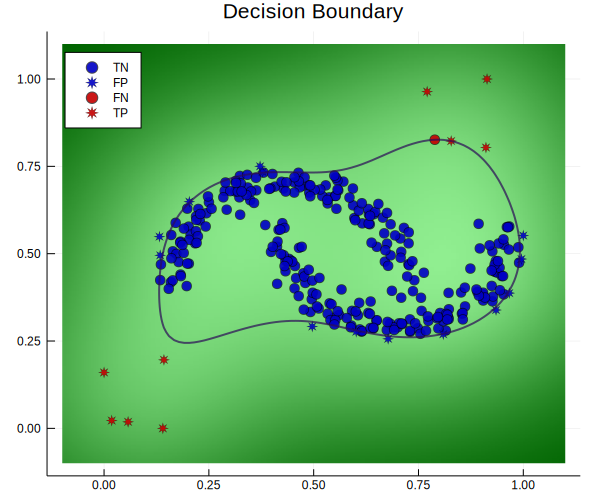

In [9]:
Plots.plot(vanilla_model, labels, grid_resolution=100, axis_overhang=0.1, legend = :topleft)

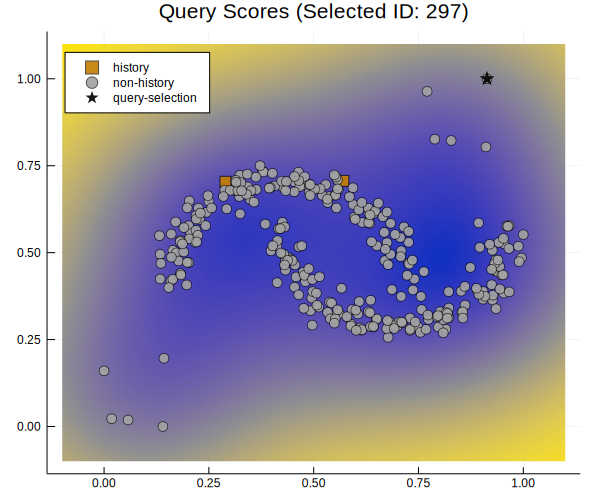

In [10]:
# qs = DecisionBoundaryPQs(vanilla_model)
qs = HighConfidencePQs(vanilla_model)
history = [112, 81]
plot(vanilla_model, qs, history, grid_resolution=100, axis_overhang=0.1, legend = :topleft)

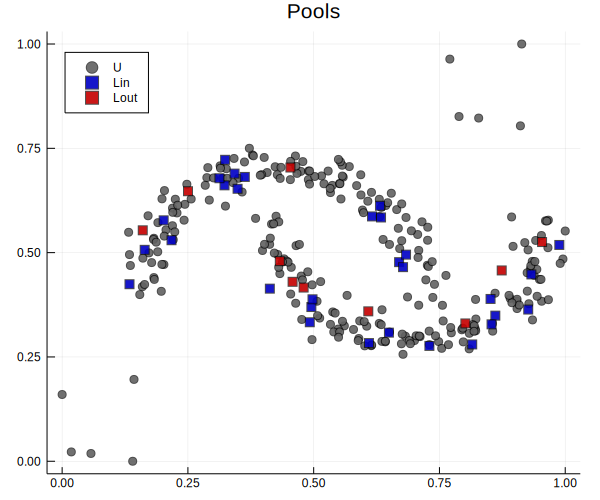

In [11]:
plot(vanilla_model, labelmap(pools), legend = :topleft)

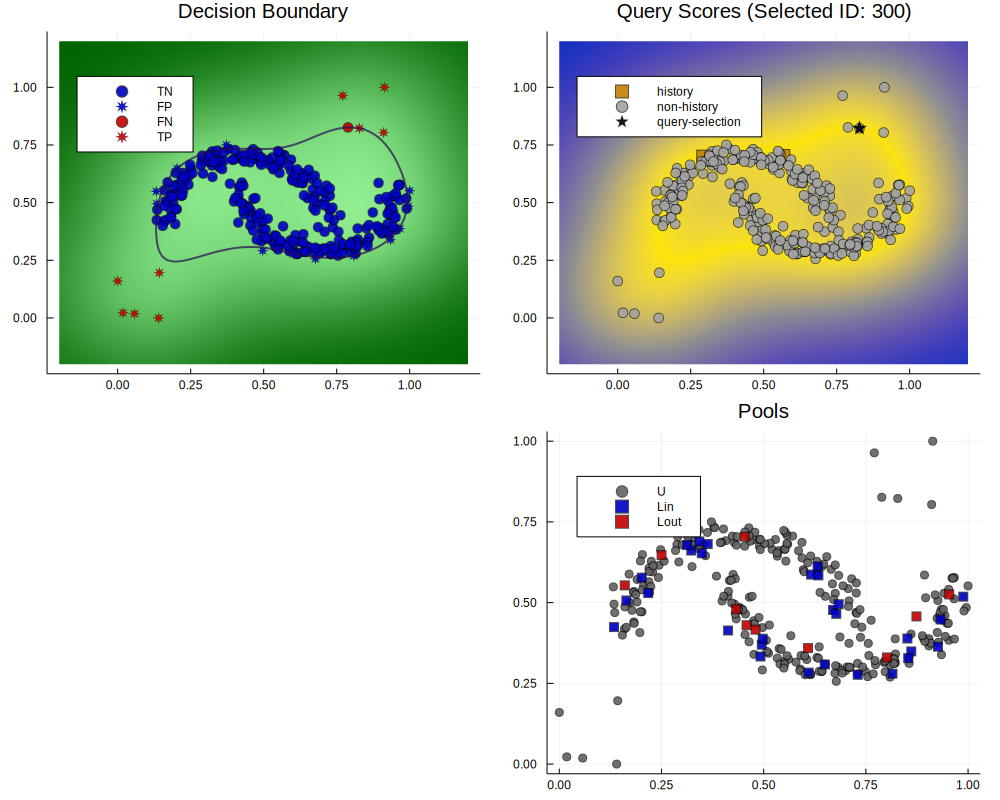

In [12]:
gr(size=(1000, 800))

qs = DecisionBoundaryPQs(vanilla_model)

Plots.plot(vanilla_model, qs, history, labels, labelmap(pools), legend = :topleft)